# Seminar 8. REAL-NVP  Modified

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from collections import defaultdict
from tqdm.notebook import tqdm
from typing import Tuple
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

USE_CUDA = torch.cuda.is_available()


We have already familiarized ourselves with normalizing flows and REAL-nvp method. For best understanding ,please, write the paper [RealNVP](https://arxiv.org/abs/1605.08803).

## 1. Data

In [7]:
TICKS_FONT_SIZE = 12
LEGEND_FONT_SIZE = 12
LABEL_FONT_SIZE = 14
TITLE_FONT_SIZE = 16

In [4]:
def visualize_2d_data(train_data, test_data, train_labels=None, test_labels=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.set_title('train', fontsize=TITLE_FONT_SIZE)
    ax1.scatter(train_data[:, 0], train_data[:, 1], s=1, c=train_labels)
    ax1.tick_params(labelsize=LABEL_FONT_SIZE)
    ax2.set_title('test', fontsize=TITLE_FONT_SIZE)
    ax2.scatter(test_data[:, 0], test_data[:, 1], s=1, c=test_labels)
    ax2.tick_params(labelsize=LABEL_FONT_SIZE)
    plt.show()

In [5]:
def generate_moons_data(count: int) -> tuple:
    data, labels = make_moons(n_samples=count, noise=0.1)
    data = data.astype("float32")
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    train_labels, test_labels = labels[:split], labels[split:]
    return train_data, train_labels, test_data, test_labels

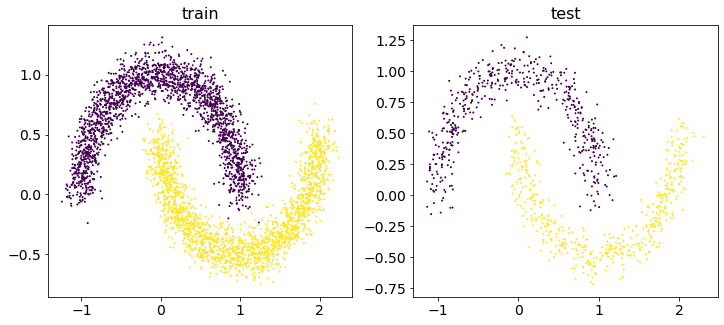

In [8]:
COUNT = 5000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)
visualize_2d_data(train_data, test_data, train_labels, test_labels)

## 2. Transformation

REAL-NVP model is a sequence of the affine coupling layers.  

Forward transform:
$$
    \begin{cases}
        \mathbf{y}_1 &= \mathbf{x}_1; \\
        \mathbf{y}_2 &= \mathbf{x}_2 \odot \exp (s(\mathbf{x}_1)) + t(\mathbf{x}_1).
    \end{cases} 
$$

Inverse transform:
$$
    \begin{cases}
        \mathbf{x}_1 &= \mathbf{y}_1; \\
        \mathbf{x}_2 &= (\mathbf{y}_2 - t(\mathbf{y}_1)) \odot \exp ( - s(\mathbf{y}_1)).
    \end{cases} 
$$

Here $s(\cdot)$ and $t(\cdot)$ are outputs of neural network. In this task our networks will be fully connected MLP.

In [9]:
class FullyConnectedMLP(nn.Module):
    def __init__(self, input_shape: int, hiddens: list, output_shape: int) -> None:
        assert isinstance(hiddens, list)
        super().__init__()
        self.input_shape = (input_shape,)
        self.output_shape = (output_shape,)
        self.hiddens = hiddens

        model = []

        # ====
        # your code
        # Stack Dense layers with ReLU activation.
        # Note that you do not have to add relu after the last dense layer
        prev_h = input_shape
        for h in hiddens:
            model.append(nn.Linear(prev_h, h))
            model.append(nn.ReLU())
            prev_h = h
        model.append(nn.Linear(hiddens[-1], output_shape))
        # ====
        self.net = nn.Sequential(*model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # apply network that was defined in __init__ and return the output
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        return self.net(x).view(batch_size, *self.output_shape)
        # ====

In [11]:
class AffineCouplingLayer(nn.Module):
    def __init__(self, parity_type: bool, n_hiddens: list) -> None:
        assert isinstance(parity_type, bool)
        assert isinstance(n_hiddens, list)
        super().__init__()
        self.mask = self.build_mask(parity_type=parity_type)
        self.mlp = FullyConnectedMLP(input_shape=2, hiddens=n_hiddens, output_shape=2)

    def build_mask(self, parity_type: bool) -> torch.Tensor:
        # ====
        # your code
        # the mask is extremely simple
        # it is a float tensor of two scalars (1.0 and 0.0)
        # the partition_type defines the order of these two scalars
        if parity_type:
            return torch.FloatTensor([1.0, 0.0])
        else:
            return torch.FloatTensor([0.0, 1.0])
        # ====

    def forward(self, x: torch.Tensor, invert: bool = False) -> tuple:
        # ====
        # your code
        # 1) mask our input x, using self.mask
        # 2) apply mlp to masked input to get s and t
        batch_size = x.shape[0]
        mask = self.mask.repeat(batch_size, 1).cuda()
        x_masked = x * mask

        s, t = self.mlp(x_masked).split(1, dim=1)
        # ====

        # we invert mask here
        t = t * (1.0 - mask)
        s = s * (1.0 - mask)

        # ====
        # your code
        # apply forward (invert=False) or inverse (invert=True) transform (invert=False)
        if invert:
            x = (x - t) * torch.exp(-s)
        else:
            x = x * torch.exp(s) + t
        # ====

        # the output is transformed input
        # and logarithm of jacobian (which equals to s)
        return x, s
 

## 3. RealNVP

We are ready to define RealNVP model. The model objective is the negative value of log-likelihood. Log-likelihood is given by the change of variables (CoV) theorem:
$$
	\log p(\mathbf{x}| \boldsymbol{\theta}) = \log p(\mathbf{z}) + \log \left|\det \left(  \frac{\partial \mathbf{z}}{\partial \mathbf{x}} \right) \right| = \log p(f(\mathbf{x}, \boldsymbol{\theta})) + \log \left|\det \left( \frac{\partial f(\mathbf{x}, \boldsymbol{\theta})}{\partial \mathbf{x}} \right) \right|.
$$

In [12]:
class RealNVP(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # base distribution p(z) is normal
        self.prior = torch.distributions.Normal(torch.tensor(0.0), torch.tensor(1.0))
        # ====
        # your code
        # apply sequence of AffineCouplingLayer with alternating parity_type
        # 6 layers is sufficient (with 2 hidden layers in each affine layer)
        self.transforms = nn.ModuleList(
            [
                AffineCouplingLayer(True, n_hiddens=[64, 64]),
                AffineCouplingLayer(False, n_hiddens=[64, 64]),
                AffineCouplingLayer(True, n_hiddens=[64, 64]),
                AffineCouplingLayer(False, n_hiddens=[64, 64]),
                AffineCouplingLayer(True, n_hiddens=[64, 64]),
                AffineCouplingLayer(False, n_hiddens=[64, 64]),
            ]
        )
        # ====

    def forward(self, x: torch.Tensor, invert: bool = False) -> tuple:
        z = x
        log_det = 0.0

        # ====
        # your code
        # apply sequence of transforms and sum all of log_dets
        # if invert == True, you have to apply transforms in reversed order (from last to first!) with invert=True flag
        transforms = reversed(self.transforms) if invert else self.transforms
        for transform in transforms:
            z, delta_log_det = transform(z, invert=invert)
            log_det += delta_log_det

        # ====
        return z, log_det

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        # ====
        # your code
        # 1) make forward pass with right inverse flag
        # 2) sum log_det with log of base distribution (log p(z)) - see the formula above
        # 3) we will get tensor of shape [batch_size, 2] - sum it over the the last dimension
        z, log_det = self.forward(x, invert=False)

        return torch.sum(log_det, dim=1) + torch.sum(self.prior.log_prob(z), dim=1)
        # ====

    def loss(self, x: torch.Tensor) -> dict:
        log_prob = self.log_prob(x)
        # log_prob should be a vector of batch_size
        assert len(log_prob.shape) == 1
        return {"nll_loss": -log_prob.mean()}

    def sample(self, n: int) -> torch.Tensor:
        # ====
        # your code
        # 1) sample from the prior
        # 2) apply the forward pass with the right inverse flag
        # 3) return only the first output of the forward pass (the second is the log of determinant - we don't need it in sampling)
        z = self.prior.sample([n, 2]).cuda()
        return self.forward(z, invert=True)[0]
        # ====

## 4. Training

In [17]:
def train_epoch(
    model: object,
    train_loader: object,
    optimizer: object,
    use_cuda: bool,
    loss_key: str = "total",
) -> defaultdict:
    model.train()

    stats = defaultdict(list)
    for x in train_loader:
        if use_cuda:
            x = x.cuda()
        losses = model.loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())

    return stats


def eval_model(model: object, data_loader: object, use_cuda: bool) -> defaultdict:
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            if use_cuda:
                x = x.cuda()
            losses = model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(
    model: object,
    train_loader: object,
    test_loader: object,
    epochs: int,
    lr: float,
    use_tqdm: bool = False,
    use_cuda: bool = False,
    loss_key: str = "total_loss",
) -> Tuple[dict, dict]:
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)
    if use_cuda:
        model = model.cuda()

    for epoch in forrange:
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, use_cuda, loss_key)
        test_loss = eval_model(model, test_loader, use_cuda)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return dict(train_losses), dict(test_losses)

In [13]:
# ====
# your code
# choose these parameters

BATCH_SIZE = 128  # any adequate value
EPOCHS = 50  # < 100
LR = 0.001  # < 1e-2
# ====

COUNT = 5000

train_data, train_labels, test_data, test_labels = generate_moons_data(COUNT)

loader_args = dict(batch_size=BATCH_SIZE, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_data, **loader_args)
test_loader = torch.utils.data.DataLoader(test_data, **loader_args)

# model
model = RealNVP()

 

In [20]:
# train
train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    loss_key="nll_loss",
    use_cuda=USE_CUDA,
    use_tqdm=True,
)


## 5.inference

In [21]:
def plot_training_curves(train_losses, test_losses, logscale_y=False, logscale_x=False):
    n_train = len(train_losses[list(train_losses.keys())[0]])
    n_test = len(test_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, n_test - 1, n_train)
    x_test = np.arange(n_test)

    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + '_train')

    for key, value in test_losses.items():
        plt.plot(x_test, value, label=key + '_test')

    if logscale_y:
        plt.semilogy()
    
    if logscale_x:
        plt.semilogx()

    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.xlabel('Epoch', fontsize=LABEL_FONT_SIZE)
    plt.ylabel('Loss', fontsize=LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    plt.grid()
    plt.show()


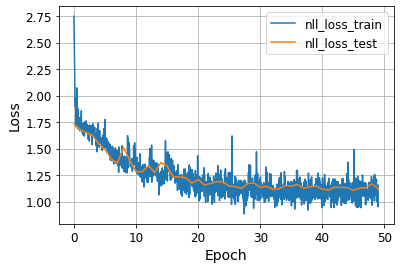

In [22]:
plot_training_curves(train_losses, test_losses)

In [24]:
def visualize_2d_densities(x_grid, y_grid, densities, title, xlabel=None, ylabel=None):
    densities = densities.reshape([y_grid.shape[0], y_grid.shape[1]])
    plt.figure(figsize=(5, 5))
    plt.pcolor(x_grid, y_grid, densities)
    plt.pcolor(x_grid, y_grid, densities)

    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=LABEL_FONT_SIZE)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=LABEL_FONT_SIZE)
    plt.show()
    

In [26]:
def visualize_2d_samples(data, title, labels=None, xlabel=None, ylabel=None):
    plt.figure(figsize=(5, 5))
    plt.scatter(data[:, 0], data[:, 1], s=1, c=labels)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=LABEL_FONT_SIZE)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=LABEL_FONT_SIZE)
    plt.show()

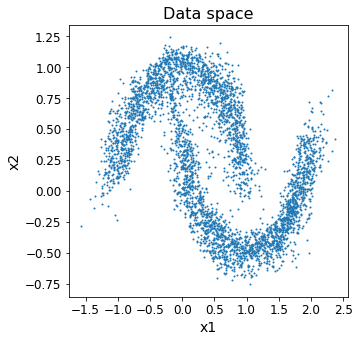

<ipython-input-24-2953d9ef525c>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_grid, y_grid, densities)
<ipython-input-24-2953d9ef525c>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(x_grid, y_grid, densities)


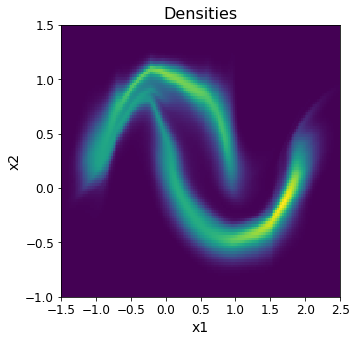

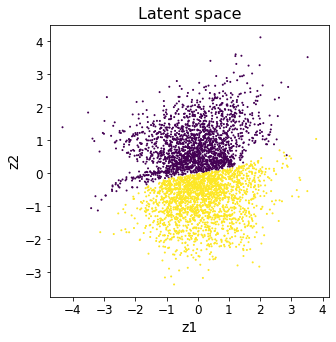

In [27]:
# Samples

x_samples = model.sample(4000).cpu().detach().numpy()
visualize_2d_samples(x_samples, title="Data space", xlabel="x1", ylabel="x2")

# Density
dx, dy = 0.025, 0.025
x_lim = (-1.5, 2.5)
y_lim = (-1, 1.5)
y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy), slice(x_lim[0], x_lim[1] + dx, dx)]
mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))

if USE_CUDA:
    mesh_xs = mesh_xs.cuda()

densities = np.exp(model.log_prob(mesh_xs).cpu().detach().numpy())

# Latents
train_tensor = torch.FloatTensor(train_data)
if USE_CUDA:
    train_tensor = train_tensor.cuda()
z = model(train_tensor)[0]
latents = z.cpu().detach().numpy()
 
visualize_2d_densities(x, y, densities, title="Densities", xlabel="x1", ylabel="x2")
visualize_2d_samples(
    latents, title="Latent space", labels=train_labels, xlabel="z1", ylabel="z2"
)